# StackOverflow data analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

## First Step: Gather and Assess Data

In [ ]:
# Gather data for years 2017 ro 2020

for year in [2017, 2018, 2019, 2020]:
    exec(f'Data{str(year)} = pd.read_csv("Stackoverflow_Data/survey_results_public_"+str(year)+".csv")')


#### Now we have 4 dataframes with datasets from 2017 to 2020 respectively with names Data2017, Data2018, Data2019 and Data2020

### Functions to be used throughout the notebook

In [ ]:
def get_list_unique_lang(df, column_name):
    """
    get list of unique language names from a specific column
    
    Input:
    df -- dataframe or the given dataset
    column_name -- Languages column to work with
    
    Output:
    list of unique languages
    
    """
    List_of_Current_Languages_joined = ', '.join(df[column_name].str.replace(';',','))
    List_of_Current_Languages = List_of_Current_Languages_joined.replace(r"/",',').replace(' ','').split(',')

    # List_of_Current_Languages
    List_of_Current_Languages_unique = set(List_of_Current_Languages)
    print('The number of unique current working languages is: ' + str(len(List_of_Current_Languages_unique)))

    return List_of_Current_Languages_unique

    
def compare_current_desired_lang(List_of_Current_Languages_unique, List_of_Desired_Languages_unique):
    """
    compare two lists of languages and check if they are the same or not
    
    Input:
    List_of_Current_Languages_unique -- list of current working languages
    List_of_Desired_Languages_unique -- list of desired working languages
    
    Output:
    True of the two lists are identical and False otherwise
    
    
    """
#Are the two list equal?
    if List_of_Current_Languages_unique == List_of_Desired_Languages_unique: 
        print("The two lists oflanguages are the same.")
        return True
    else:
        return False

    
def get_list_lang_same(List_of_Current_Languages_unique, List_of_Desired_Languages_unique):
    """
    Given two lists of languages and check if they are the same or not, output the uniue languages if they are both the same
    
    Input:
    List_of_Current_Languages_unique -- list of current working languages
    List_of_Desired_Languages_unique -- list of desired working languages
    
    Output:
    list of unique languages
    
    """
    if compare_current_desired_lang(List_of_Current_Languages_unique, List_of_Desired_Languages_unique):
        List_of_Languages = List_of_Current_Languages_unique
        List_of_Languages.remove('')
        print(List_of_Languages)
        return List_of_Languages
    

In [4]:
def count_occurence_lang_per_year(df, column_to_count, other_column_to_drop):
    """
    Count Programming or DB languages in Current Working and Desired Columns based on input
    
    Input:
    df -- dataframe with data
    column_to_count -- column name to count number of occurance either Current_Programming language, 
                        Desire Programming Laguage, Current DB Lang or Desire DB Lang
    other_column_to_drop -- column to be dropped from dataframe (Current in case of counting Desired and 
                                                                  Desired in case of counting current)
    
    Output:
    Dataframe with Languages and their count per year
    """
    ## Count Occurences of each Language in Current per Year
    Count_Current_df = df.assign(var1=df[column_to_count].str.split(';')).explode('var1')

    Count_Current_df.rename(columns={'var1':column_to_count+'_New'}, inplace=True)
    Count_Current_df.drop(columns=[column_to_count,other_column_to_drop], inplace=True)
    Final_Count_df = Count_Current_df.value_counts()
    Final_Count_df = Final_Count_df.to_frame()
    Final_Count_df.reset_index(inplace=True)
    Final_Count_df.columns = ['Year',column_to_count+'_New','Counts']
    return Final_Count_df.sort_values(by=['Year','Counts'], ascending=False)


def plot_top5_lang_per_year(count_df, column_name, years=['2017','2018','2019','2020']):
    """
    plot count of languages per year
    
    Input:
    count_df -- dataframe with language count per year
    column_name -- Language column in the dataset to be counted
    years -- list of years, by default ['2017','2018','2019','2020']
    
    Output:
    no output just the plot
    """
    for year in years:
        print('The top 5 languages in year '+ str(year) + ': \n')
        print(count_df[count_df['Year'] == year][column_name].head(5).to_list())
        print('\n')
        plt.figure(str(year).index(str(year)))
        sns.barplot(x = 'Counts', 
                    y = column_name,
                    data = count_df[count_df['Year'] == year].head(5))
        plt.show()

In [5]:
def get_column_names(dataset, Prog_or_DB='Prog'):
    """
    Input:
    dataset -- dataset name (dataframe name)
    Prog_or_DB -- string with 'Prog' for Programming Languages and 'DB' for database languages
    
    Output:
    List of column names with Current and Desired Prog/DB languages
    """
    columns = []
    if Prog_or_DB == 'DB':
        columns.append(dataset.columns[dataset.columns.str.contains('Database') & dataset.columns.str.contains('Work')][0])
        columns.append(dataset.columns[dataset.columns.str.contains('Database') & (dataset.columns.str.contains('Desire') | dataset.columns.str.contains('Want'))][0])
    elif Prog_or_DB == 'Prog':
        columns.append(dataset.columns[dataset.columns.str.contains('Language') & dataset.columns.str.contains('Work')][0])
        columns.append(dataset.columns[dataset.columns.str.contains('Language') & (dataset.columns.str.contains('Desire') | dataset.columns.str.contains('Want'))][0])


    return columns
       

def create_combined_dataset(datasets=[Data2017, Data2018, Data2019, Data2020], Prog_or_DB='Prog'):
    """
    
    Extracting Language columns from all datasets and add a Year column 
    and create a new combined dataset to work with
    
    Input:
    datasets -- list of datasets to be combined, by default: [Data2017, Data2018, Data2019, Data2020]
    Prog_or_DB -- string with 'Prog' for Programming Languages and 'DB' for database languages
    
    Output:
    combined dataset as dataframe
    
    
    """
    Current_vs_Desired_Language = pd.DataFrame()
    Years = [2017, 2018, 2019, 2020]
    
    count = 0
    for dataset in datasets:
        if Prog_or_DB == 'DB':
            columns = ['Respondent','Year', get_column_names(dataset, Prog_or_DB='DB')[0], get_column_names(dataset, Prog_or_DB='DB')[1]]
        elif Prog_or_DB == 'Prog':
            columns = ['Respondent','Year', get_column_names(dataset, Prog_or_DB='Prog')[0], get_column_names(dataset, Prog_or_DB='Prog')[1]]
        dataset['Year'] = Years[count]
        count += 1
#         Current_vs_Desired_Language.columns = columns
        Current_vs_Desired_Language = Current_vs_Desired_Language.append(dataset[columns])

    return Current_vs_Desired_Language



def unify_Lang_column_names(df):
    """
    unify Language column names across datasets in the combined dataset 
    by taking values from various columns and combine them into one column
    
    Input:
    df -- combined dataset
    
    Output:
    dataset with replacing various Language column 
    into two columns one for Current Working Language and one for Desired Language
    
    
    """
    columns = list(df.columns)
    if 'Year' in columns:
        columns.remove('Year')
    if 'Respondent' in columns:
        columns.remove('Respondent')
    work_columns = [s for s in df.columns if "Work" in s and "Desire" not in s and "Want" not in s]
    desired_columns = [s for s in df.columns if "Desire" in s or "Want" in s]
    df['CurrentWorkingLanguage'] = df[work_columns[0]].fillna('').astype(str) + df[work_columns[1]].fillna('').astype(str)
    df['DesiredLanguage'] = df[desired_columns[0]].fillna('').astype(str) + df[desired_columns[1]].fillna('').astype(str)
    df = df.drop(columns=columns)
    return df




# Check the top languages used in the last 4 years

### Create a combined dataset with all 4 datasets

In [6]:
Languages_with_years = create_combined_dataset(datasets=[Data2017, Data2018, Data2019, Data2020], Prog_or_DB='Prog')

# Remove 'Respondent' column as it is not in the ssxope of this part
Languages_with_years = Languages_with_years.drop('Respondent', axis=1)    
Languages_with_years.head()

,Year,HaveWorkedLanguage,WantWorkLanguage,LanguageWorkedWith,LanguageDesireNextYear
0,2017,Swift,Swift,NaN,NaN
1,2017,JavaScript; Python; Ruby; SQL,Java; Python; Ruby; SQL,NaN,NaN
2,2017,Java; PHP; Python,C; Python; Rust,NaN,NaN
3,2017,Matlab; Python; R; SQL,Matlab; Python; R; SQL,NaN,NaN
4,2017,NaN,NaN,NaN,NaN


### Cleaning Data and working with missing values

In [7]:
# Drop rows with all nulls
# Drop rows with all nulls as they are not needed and will not affect the results. In addition, we cannot replace null values in this objective
Languages_with_years = Languages_with_years.dropna(subset=['HaveWorkedLanguage','WantWorkLanguage','LanguageWorkedWith','LanguageDesireNextYear'], how='all', axis=0)

# Unifying column names
Languages_with_years = unify_Lang_column_names(Languages_with_years)
Languages_with_years.head()

,Year,CurrentWorkingLanguage,DesiredLanguage
0,2017,Swift,Swift
1,2017,JavaScript; Python; Ruby; SQL,Java; Python; Ruby; SQL
2,2017,Java; PHP; Python,C; Python; Rust
3,2017,Matlab; Python; R; SQL,Matlab; Python; R; SQL
5,2017,JavaScript; PHP; Rust,Clojure; Elixir; Erlang; Haskell; Rust; TypeSc...


## Get a list of unique Programming Languages used by current workers as well as the desired programming languages to be used in the future

In [8]:
List_of_Current_Languages_unique = get_list_unique_lang(Languages_with_years, 'CurrentWorkingLanguage')
List_of_Desired_Languages_unique = get_list_unique_lang(Languages_with_years, 'DesiredLanguage')
List_of_Languages = get_list_lang_same(List_of_Current_Languages_unique, List_of_Desired_Languages_unique)

The number of unique current working languages is: 48
The number of unique current working languages is: 48
The two lists oflanguages are the same.
{'JavaScript', 'Rust', 'Hack', 'Haskell', 'Shell', 'Swift', 'Ocaml', 'CoffeeScript', 'Elixir', 'C', 'PHP', 'C++', 'Perl', 'VisualBasic6', 'Lua', 'Dart', 'Objective-C', 'Scala', 'CSS', 'F#', 'PowerShell', 'Assembly', 'Python', 'Clojure', 'Matlab', 'Go', 'WebAssembly', 'ObjectPascal', 'CommonLisp', 'Groovy', 'Delphi', 'Kotlin', 'HTML', 'Bash', 'SQL', 'Julia', 'Other(s):', 'R', 'TypeScript', 'VBA', 'Java', 'Smalltalk', 'Cobol', 'Ruby', 'Erlang', 'C#', 'VB.NET'}


## Analysis and Visualization of Programming Languages data

For the Current Working Programming Languages
The top 5 languages in year 2017: 

[' SQL', ' JavaScript', ' Python', ' PHP', ' Java']




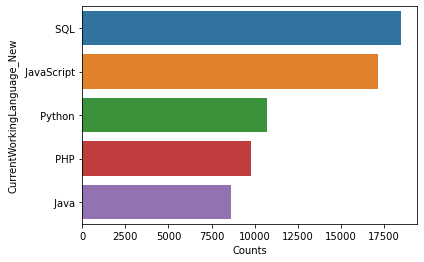

The top 5 languages in year 2018: 

['JavaScript', 'HTML', 'CSS', 'SQL', 'Java']




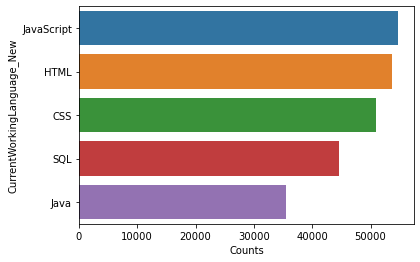

The top 5 languages in year 2019: 

['JavaScript', 'HTML/CSS', 'SQL', 'Python', 'Java']




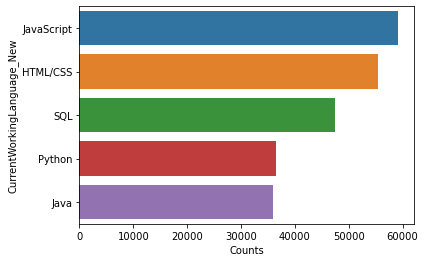

The top 5 languages in year 2020: 

['JavaScript', 'HTML/CSS', 'SQL', 'Python', 'Java']




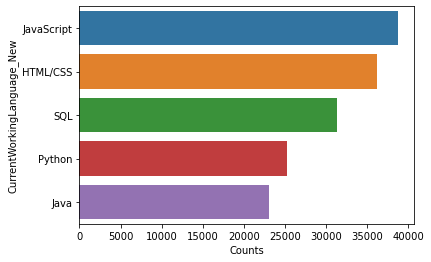

For the Desired Working Programming Languages
The top 5 languages in year 2017: 

[' JavaScript', ' Python', ' SQL', 'C#', ' Java']




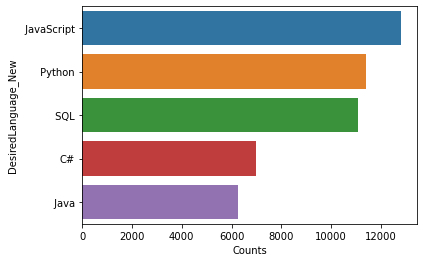

The top 5 languages in year 2018: 

['JavaScript', 'Python', 'HTML', 'CSS', 'SQL']




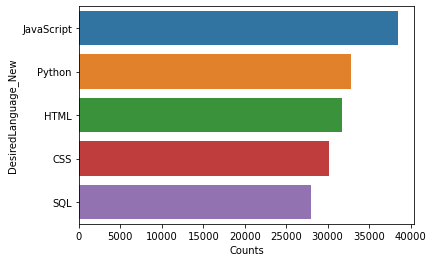

The top 5 languages in year 2019: 

['JavaScript', 'Python', 'HTML/CSS', 'SQL', 'TypeScript']




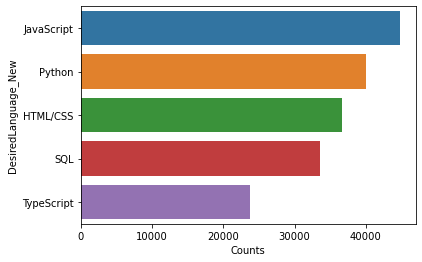

The top 5 languages in year 2020: 

['Python', 'JavaScript', 'HTML/CSS', 'SQL', 'TypeScript']




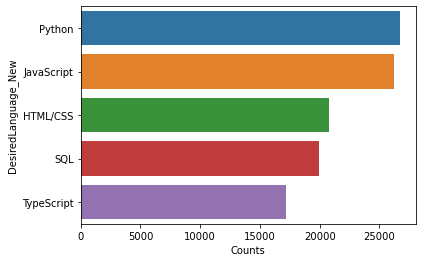

In [10]:
# ## Count Occurences of each Language in Current per Year

Final_Count_df = count_occurence_lang_per_year(Languages_with_years, 'CurrentWorkingLanguage', 'DesiredLanguage')
Final_Count_df.head()
print('For the Current Working Programming Languages')
plot_top5_lang_per_year(Final_Count_df, 'CurrentWorkingLanguage_New', years=[2017, 2018, 2019, 2020])

# print('-------------------------------------------')    

# ## Count Occurences of each Language in Desired per Year
 
Final_Count_Desired_df = count_occurence_lang_per_year(Languages_with_years, 'DesiredLanguage', 'CurrentWorkingLanguage')
print('For the Desired Working Programming Languages')
plot_top5_lang_per_year(Final_Count_Desired_df, 'DesiredLanguage_New', years=[2017, 2018, 2019, 2020])



<AxesSubplot:xlabel='Counts', ylabel='CurrentWorkingLanguage_New'>

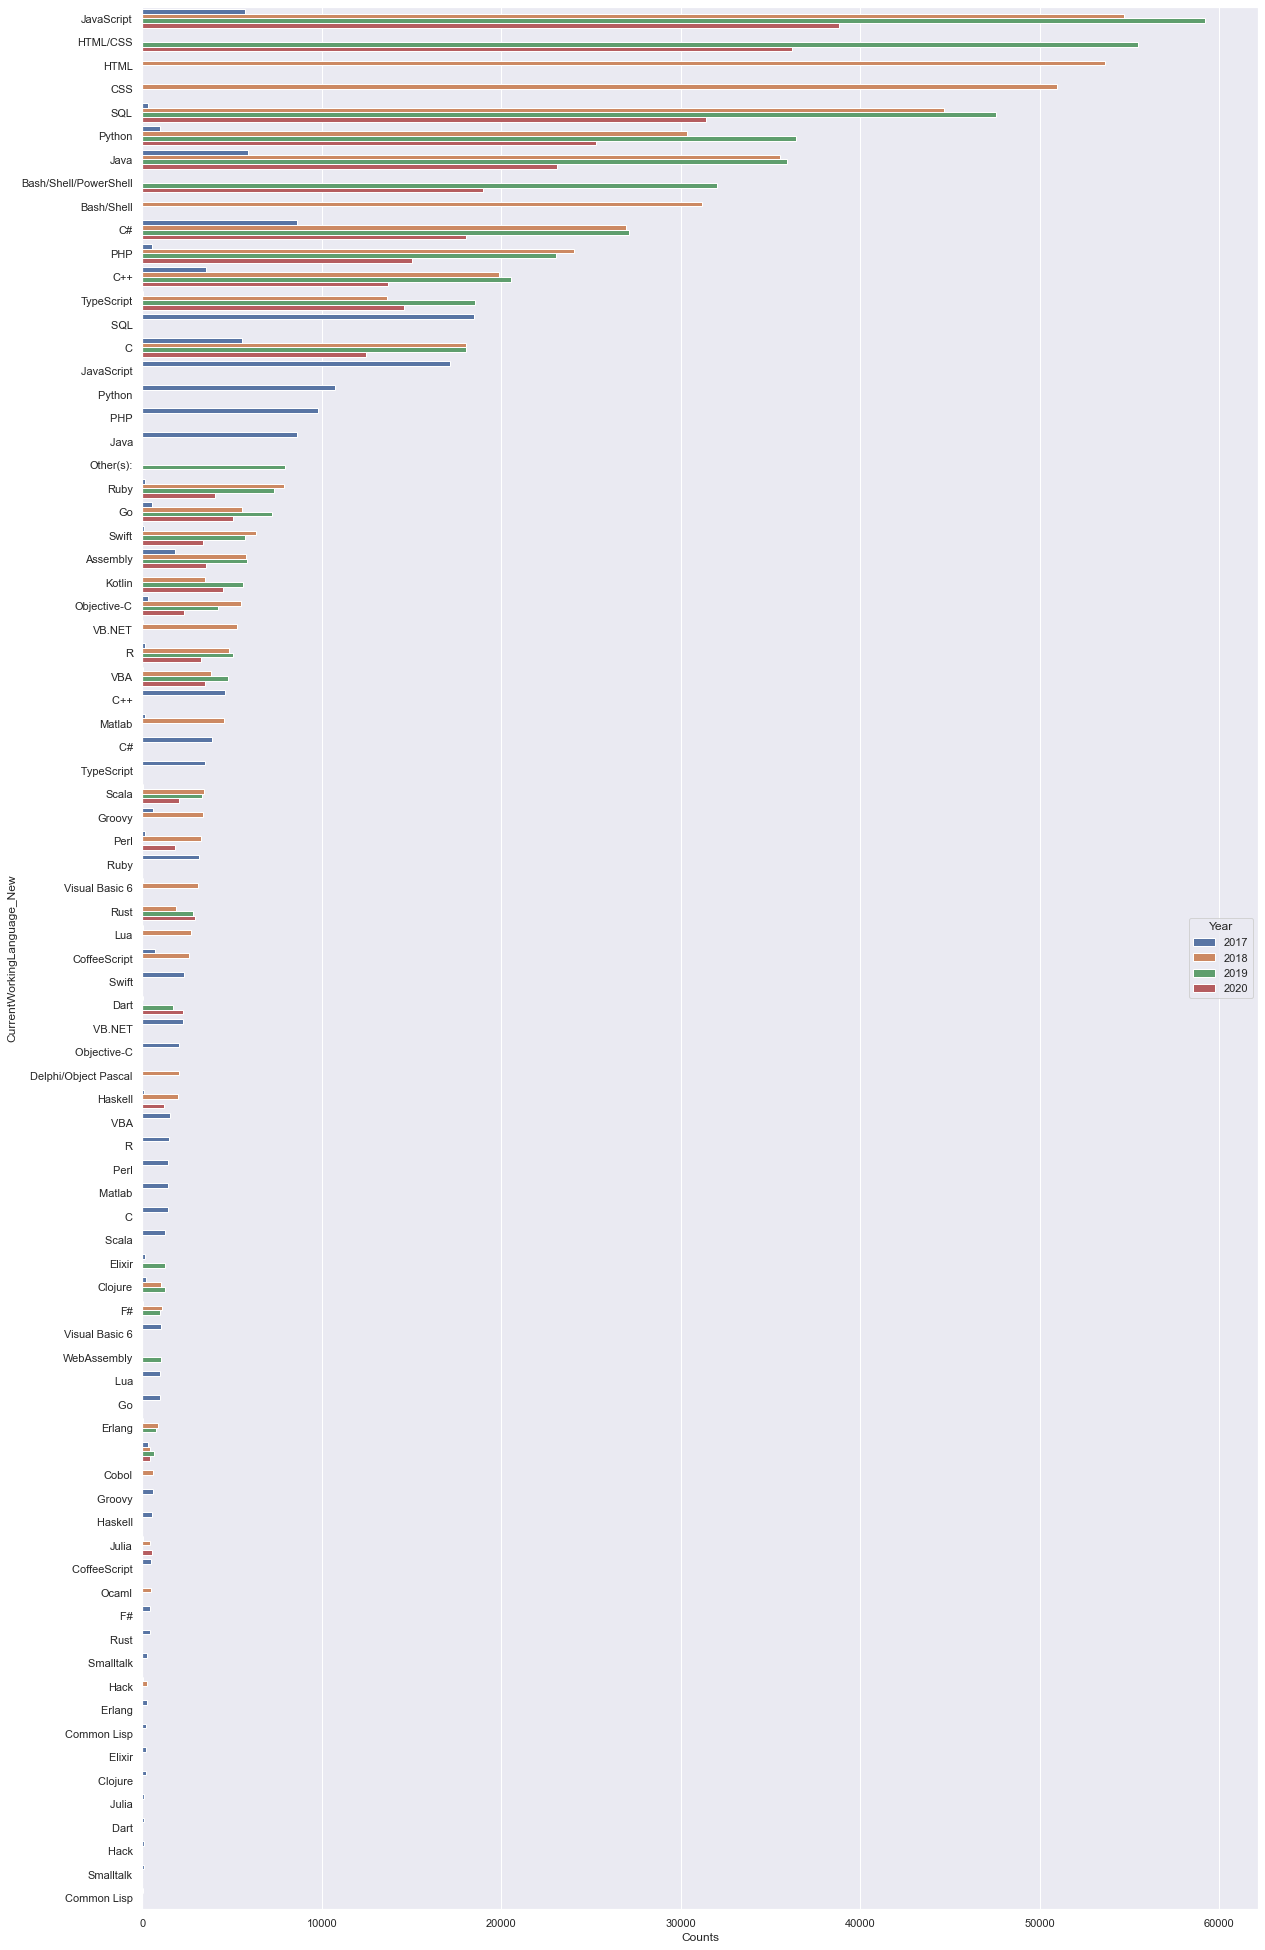

In [11]:
# Plot all Current Languags with the counts
sns.set(rc={'figure.figsize':(20,35)})
sns.barplot(x = 'Counts', 
            y = 'CurrentWorkingLanguage_New',
            hue = 'Year',
            data = Final_Count_df.sort_values(by='Counts', ascending=False))

<AxesSubplot:xlabel='Counts', ylabel='DesiredLanguage_New'>

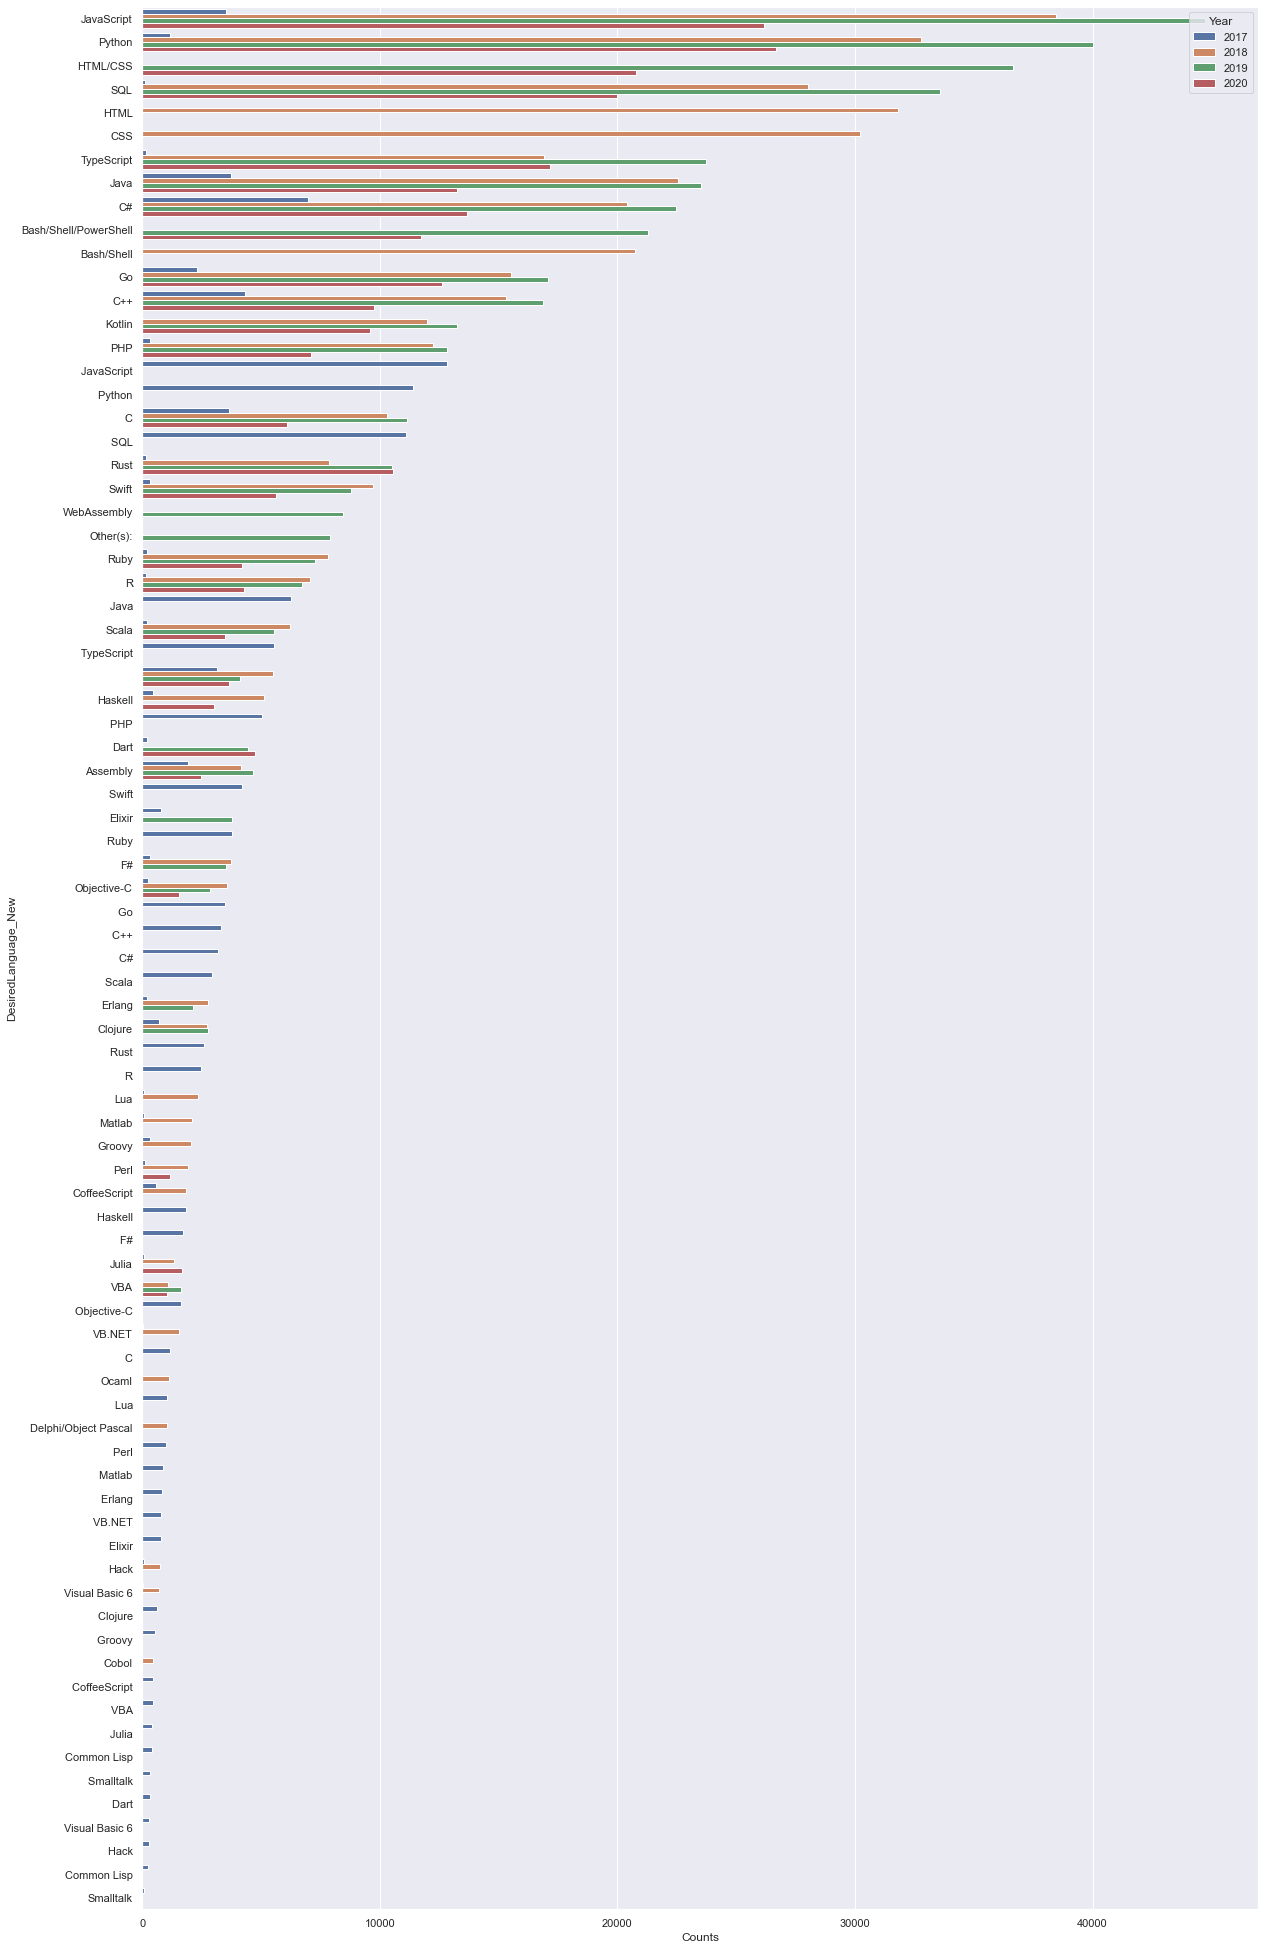

In [12]:
# Plot all Desired Languags with the counts
sns.barplot(x = 'Counts', 
            y = 'DesiredLanguage_New',
            hue = 'Year',
            data = Final_Count_Desired_df.sort_values(by='Counts', ascending=False))

## How working with databases change over the years?

### Create a combined dataset with all 4 datasets (Database Lang)


In [13]:
DB_Languages_with_years = create_combined_dataset(datasets=[Data2017, Data2018, Data2019, Data2020], Prog_or_DB='DB')

# Remove 'Respondent' column as it is not in the ssxope of this part
DB_Languages_with_years = DB_Languages_with_years.drop('Respondent', axis=1)    
DB_Languages_with_years.head()




,Year,HaveWorkedDatabase,WantWorkDatabase,DatabaseWorkedWith,DatabaseDesireNextYear
0,2017,NaN,NaN,NaN,NaN
1,2017,MySQL; SQLite,MySQL; SQLite,NaN,NaN
2,2017,MySQL,NaN,NaN,NaN
3,2017,MongoDB; Redis; SQL Server; MySQL; SQLite,MongoDB; Redis; SQL Server; MySQL; SQLite,NaN,NaN
4,2017,NaN,NaN,NaN,NaN


### Cleaning Data and working with missing values

In [14]:
# Drop rows with all nulls
# Drop rows with all nulls as they are not needed and will not affect the results. In addition, we cannot replace null values in this objective
DB_Languages_with_years = DB_Languages_with_years.dropna(subset=['HaveWorkedDatabase','WantWorkDatabase','DatabaseWorkedWith','DatabaseDesireNextYear'], how='all', axis=0)

# Unifying column names
# DB_Languages_with_years['CurrentWorkingDBLanguage'] = DB_Languages_with_years['HaveWorkedDatabase'].fillna('').astype(str) + DB_Languages_with_years['DatabaseWorkedWith'].fillna('').astype(str)
# DB_Languages_with_years['DesiredDBLanguage'] = DB_Languages_with_years['WantWorkDatabase'].fillna('').astype(str) + DB_Languages_with_years['DatabaseDesireNextYear'].fillna('').astype(str)
# DB_Languages_with_years = DB_Languages_with_years.drop(columns=['HaveWorkedDatabase','WantWorkDatabase','DatabaseWorkedWith','DatabaseDesireNextYear'])

DB_Languages_with_years = unify_Lang_column_names(DB_Languages_with_years)

DB_Languages_with_years.head()



,Year,CurrentWorkingLanguage,DesiredLanguage
1,2017,MySQL; SQLite,MySQL; SQLite
2,2017,MySQL,
3,2017,MongoDB; Redis; SQL Server; MySQL; SQLite,MongoDB; Redis; SQL Server; MySQL; SQLite
5,2017,MySQL,
6,2017,SQLite,MongoDB; SQL Server; PostgreSQL; SQLite


### Get a list of unique DB Languages used by current workers as well as the desired DB languages to be used in the future

In [15]:
List_of_Current_DB_Languages_unique = get_list_unique_lang(DB_Languages_with_years, 'CurrentWorkingLanguage')
List_of_Desired_DB_Languages_unique = get_list_unique_lang(DB_Languages_with_years, 'DesiredLanguage')
List_of_Languages = get_list_lang_same(List_of_Current_DB_Languages_unique, List_of_Desired_DB_Languages_unique)


The number of unique current working languages is: 32
The number of unique current working languages is: 32
The two lists oflanguages are the same.
{'GoogleCloudStorage', 'Elasticsearch', 'GoogleBigQuery', 'IBMDb2', 'SQLite', 'ApacheHBase', 'Memcached', 'SQLServer', 'AmazonRedshift', 'ApacheHive', 'MariaDB', 'Aurora', 'AmazonDynamoDB', 'DynamoDB', 'Couchbase', 'Neo4j', 'CosmosDB', 'SQL', 'PostgreSQL', 'Other(s):', 'etc)', 'AmazonRDS', 'Oracle', 'MongoDB', 'MicrosoftAzure(Tables', 'Firebase', 'IBMDB2', 'Redis', 'MicrosoftSQLServer', 'Cassandra', 'MySQL'}


## Analysis and Visualization of DB Languages data

For the Current Working DB Languages
The top 5 languages in year 2017: 

['SQL Server', ' MySQL', 'MySQL', ' SQLite', ' PostgreSQL']




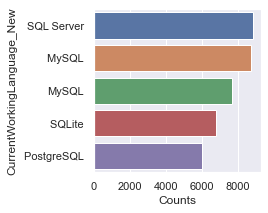

The top 5 languages in year 2018: 

['MySQL', 'SQL Server', 'PostgreSQL', 'MongoDB', 'SQLite']




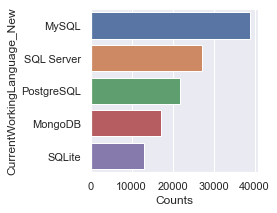

The top 5 languages in year 2019: 

['MySQL', 'PostgreSQL', 'Microsoft SQL Server', 'SQLite', 'MongoDB']




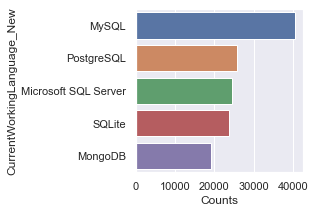

The top 5 languages in year 2020: 

['MySQL', 'PostgreSQL', 'Microsoft SQL Server', 'SQLite', 'MongoDB']




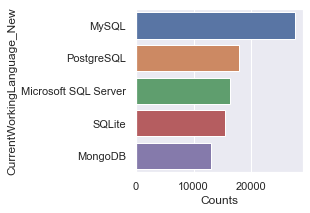

-------------------------------------------
For the Desired Working DB Languages
The top 5 languages in year 2017: 

['MongoDB', ' MySQL', ' PostgreSQL', '', ' SQLite']




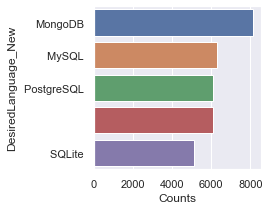

The top 5 languages in year 2018: 

['MySQL', 'MongoDB', 'PostgreSQL', 'SQL Server', 'Redis']




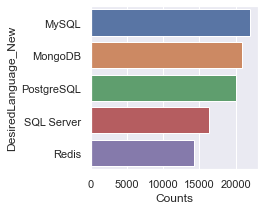

The top 5 languages in year 2019: 

['PostgreSQL', 'MySQL', 'MongoDB', 'Redis', 'SQLite']




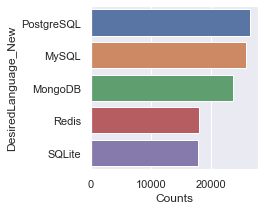

The top 5 languages in year 2020: 

['PostgreSQL', 'MongoDB', 'MySQL', 'Redis', 'SQLite']




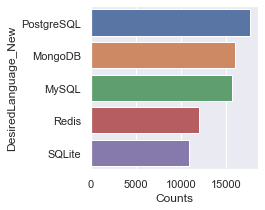

In [16]:
sns.set(rc={'figure.figsize':(3,3)})

Final_Count_DB_df = count_occurence_lang_per_year(DB_Languages_with_years, 'CurrentWorkingLanguage', 'DesiredLanguage')
print('For the Current Working DB Languages')
plot_top5_lang_per_year(Final_Count_DB_df, 'CurrentWorkingLanguage_New', years=[2017, 2018, 2019, 2020])    

print('-------------------------------------------')    


Final_Count_Desired_DB_df = count_occurence_lang_per_year(DB_Languages_with_years, 'DesiredLanguage', 'CurrentWorkingLanguage')
print('For the Desired Working DB Languages')
plot_top5_lang_per_year(Final_Count_Desired_DB_df, 'DesiredLanguage_New', years=[2017, 2018 , 2019, 2020])    



<AxesSubplot:xlabel='Counts', ylabel='CurrentWorkingLanguage_New'>

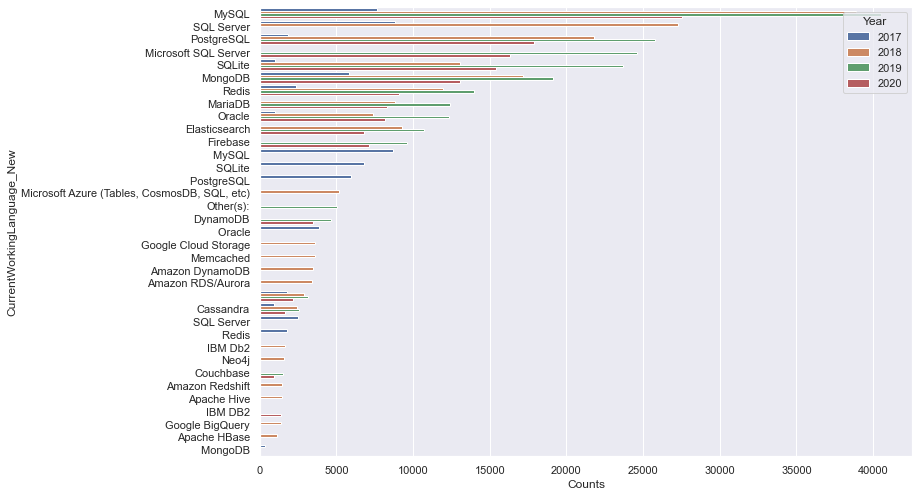

In [17]:
# Plot all Current DB Languages with the counts
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x = 'Counts', 
            y = 'CurrentWorkingLanguage_New',
            hue = 'Year',
            data = Final_Count_DB_df.sort_values(by='Counts', ascending=False))

<AxesSubplot:xlabel='Counts', ylabel='DesiredLanguage_New'>

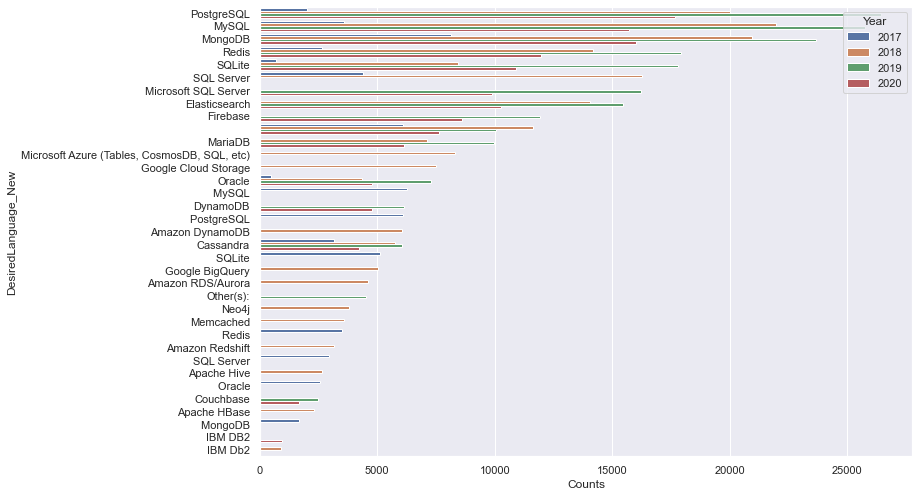

In [18]:
# Plot all Desired DB Languages with the counts
sns.barplot(x = 'Counts', 
            y = 'DesiredLanguage_New',
            hue = 'Year',
            data = Final_Count_Desired_DB_df.sort_values(by='Counts', ascending=False))

## Working vs Desired programming and db languages

### Working vs Desired Database Languages

In [19]:
Current_vs_Desired_Language = create_combined_dataset(datasets=[Data2017, Data2018, Data2019, Data2020], Prog_or_DB='DB')
Current_vs_Desired_Language.head()



,Respondent,Year,HaveWorkedDatabase,WantWorkDatabase,DatabaseWorkedWith,DatabaseDesireNextYear
0,1,2017,NaN,NaN,NaN,NaN
1,2,2017,MySQL; SQLite,MySQL; SQLite,NaN,NaN
2,3,2017,MySQL,NaN,NaN,NaN
3,4,2017,MongoDB; Redis; SQL Server; MySQL; SQLite,MongoDB; Redis; SQL Server; MySQL; SQLite,NaN,NaN
4,5,2017,NaN,NaN,NaN,NaN


In [20]:
# Drop rows with all nulls
Current_vs_Desired_Language = Current_vs_Desired_Language.dropna(subset=['DatabaseWorkedWith','DatabaseDesireNextYear'], how='all', axis=0)

# Unifying column names
# Current_vs_Desired_Language['CurrentWorkingDBLanguage'] = Current_vs_Desired_Language['HaveWorkedDatabase'].fillna('').astype(str) + Current_vs_Desired_Language['DatabaseWorkedWith'].fillna('').astype(str)
# Current_vs_Desired_Language['DesiredDBLanguage'] = Current_vs_Desired_Language['WantWorkDatabase'].fillna('').astype(str) + Current_vs_Desired_Language['DatabaseDesireNextYear'].fillna('').astype(str)
# Current_vs_Desired_Language = Current_vs_Desired_Language.drop(columns=['HaveWorkedDatabase','WantWorkDatabase','DatabaseWorkedWith','DatabaseDesireNextYear'])
Current_vs_Desired_Language = unify_Lang_column_names(Current_vs_Desired_Language)
Current_vs_Desired_Language.head()



,Respondent,Year,CurrentWorkingLanguage,DesiredLanguage
0,1,2018,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...
1,3,2018,Redis;PostgreSQL;Memcached,PostgreSQL
3,5,2018,"SQL Server;Microsoft Azure (Tables, CosmosDB, ...","SQL Server;Microsoft Azure (Tables, CosmosDB, ..."
4,7,2018,SQL Server;PostgreSQL;Oracle;IBM Db2,PostgreSQL;Oracle;IBM Db2
5,8,2018,MongoDB,PostgreSQL


In [21]:
## Current Lang alone
Current_DB_df = Current_vs_Desired_Language.assign(var1=Current_vs_Desired_Language['CurrentWorkingLanguage'].str.split(';')).explode('var1')

Current_DB_df.rename(columns={'var1':'Current_Working_DBLanguage'}, inplace=True)
Current_DB_df.drop(columns=['CurrentWorkingLanguage','DesiredLanguage'], inplace=True)
Current_DB_df



,Respondent,Year,Current_Working_DBLanguage
0,1,2018,Redis
0,1,2018,SQL Server
0,1,2018,MySQL
0,1,2018,PostgreSQL
0,1,2018,Amazon RDS/Aurora
...,...,...,...
64459,64925,2020,Oracle
64460,65112,2020,MariaDB
64460,65112,2020,Microsoft SQL Server
64460,65112,2020,MySQL


In [22]:
## Desired Lang alone
Desired_DB_df = Current_vs_Desired_Language.assign(var1=Current_vs_Desired_Language['DesiredLanguage'].str.split(';')).explode('var1')

Desired_DB_df.rename(columns={'var1':'Desired_Working_DB_Language'}, inplace=True)
Desired_DB_df.drop(columns=['CurrentWorkingLanguage','DesiredLanguage'], inplace=True)

Desired_DB_df.head(10)



,Respondent,Year,Desired_Working_DB_Language
0,1,2018,Redis
0,1,2018,SQL Server
0,1,2018,MySQL
0,1,2018,PostgreSQL
0,1,2018,Amazon RDS/Aurora
0,1,2018,"Microsoft Azure (Tables, CosmosDB, SQL, etc)"
1,3,2018,PostgreSQL
3,5,2018,SQL Server
3,5,2018,"Microsoft Azure (Tables, CosmosDB, SQL, etc)"
4,7,2018,PostgreSQL


In [23]:
#compare
# Current_DB_df
# Desired_DB_df
# What is in Current found in Desired


DB_df = pd.merge(Current_DB_df, Desired_DB_df, how='left', on=['Respondent','Year'])
   

DB_df.loc[DB_df['Current_Working_DBLanguage'] != DB_df['Desired_Working_DB_Language'],'Desired_Working_DB_Language'] = np.nan
DB_df.sort_values(by=['Respondent','Year','Current_Working_DBLanguage','Desired_Working_DB_Language'], ascending=False, inplace=True)
DB_df.drop_duplicates(subset=['Respondent','Year','Current_Working_DBLanguage'], inplace=True)
DB_df[DB_df['Respondent']==1]


## Count common between desired and current
len(DB_df[DB_df['Desired_Working_DB_Language'].isnull() == False])/len(DB_df) ## 54%
DB_df
DB_df_final = DB_df[DB_df['Desired_Working_DB_Language'].isnull() == False].drop('Respondent', axis=1)
# DB_df_final = DB_df_final.drop('Respondent', axis=1)
DB_df_final = DB_df_final.value_counts()
DB_df_final = DB_df_final.to_frame().reset_index()
DB_df_final.columns = ['Year','Current_Working_DBLanguage','Desired_Working_DB_Language','Count']

DB_df_final = DB_df_final.sort_values(by=['Year','Count'], ascending=False)
DB_df_final.head(10)

,Year,Current_Working_DBLanguage,Desired_Working_DB_Language,Count
7,2020,MySQL,MySQL,12990
8,2020,PostgreSQL,PostgreSQL,11432
12,2020,Microsoft SQL Server,Microsoft SQL Server,8318
14,2020,SQLite,SQLite,7631
15,2020,MongoDB,MongoDB,7328
19,2020,Redis,Redis,6020
24,2020,MariaDB,MariaDB,4266
25,2020,Elasticsearch,Elasticsearch,4003
26,2020,Firebase,Firebase,3914
30,2020,Oracle,Oracle,2706


49


<AxesSubplot:xlabel='Count', ylabel='Current_Working_DBLanguage'>

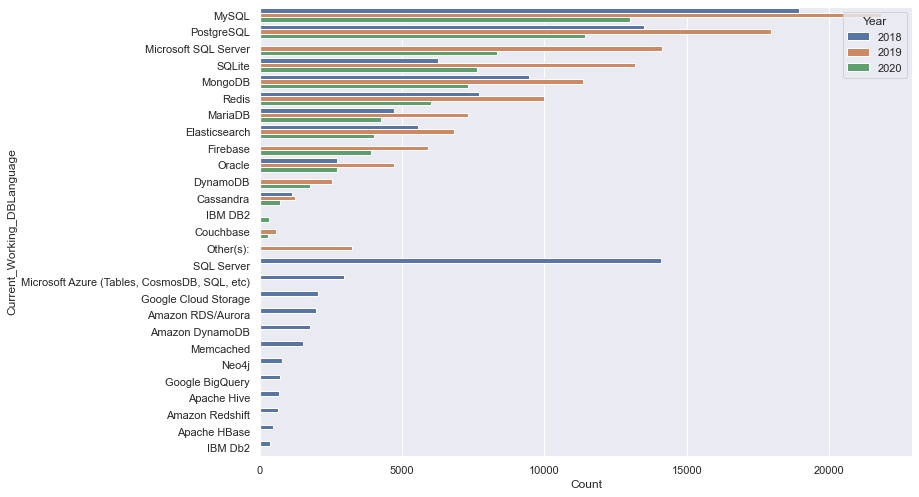

In [24]:
print(len(DB_df_final))
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x = 'Count', 
            y = 'Current_Working_DBLanguage',
            hue = 'Year',
            data = DB_df_final)

In [25]:
#compare
# Current_DB_df
# Desired_DB_df
# What is in Desired not found in Current


DB_df = pd.merge(Current_DB_df, Desired_DB_df, how='right', on=['Respondent','Year'])
   

DB_df.loc[DB_df['Current_Working_DBLanguage'] != DB_df['Desired_Working_DB_Language'],'Current_Working_DBLanguage'] = np.nan
DB_df.sort_values(by=['Respondent','Year','Current_Working_DBLanguage','Desired_Working_DB_Language'], ascending=False, inplace=True)
DB_df.drop_duplicates(subset=['Respondent','Year','Current_Working_DBLanguage'], inplace=True)
DB_df[DB_df['Respondent']==1]


## Count not found in Current
print(len(DB_df[DB_df['Current_Working_DBLanguage'].isnull() == True])/len(DB_df)) ## 37.8%
DB_df
DB_df_final = DB_df[DB_df['Current_Working_DBLanguage'].isnull() == True].drop(['Respondent','Current_Working_DBLanguage'], axis=1)
DB_df_final = DB_df_final.value_counts()
DB_df_final = DB_df_final.to_frame().reset_index()
DB_df_final.columns = ['Year','Desired_Working_DB_Language','Count']
DB_df_final = DB_df_final[DB_df_final['Desired_Working_DB_Language'] != '']
DB_df_final = DB_df_final.sort_values(by=['Year','Count'], ascending=False)
DB_df_final.head(10)

0.38472173408593363


,Year,Desired_Working_DB_Language,Count
5,2020,SQLite,10160
8,2020,Redis,8929
12,2020,PostgreSQL,6969
17,2020,MySQL,3799
18,2020,MongoDB,3709
21,2020,Oracle,1741
26,2020,Microsoft SQL Server,1104
28,2020,Firebase,1059
31,2020,Elasticsearch,896
34,2020,MariaDB,395


49


<AxesSubplot:xlabel='Count', ylabel='Desired_Working_DB_Language'>

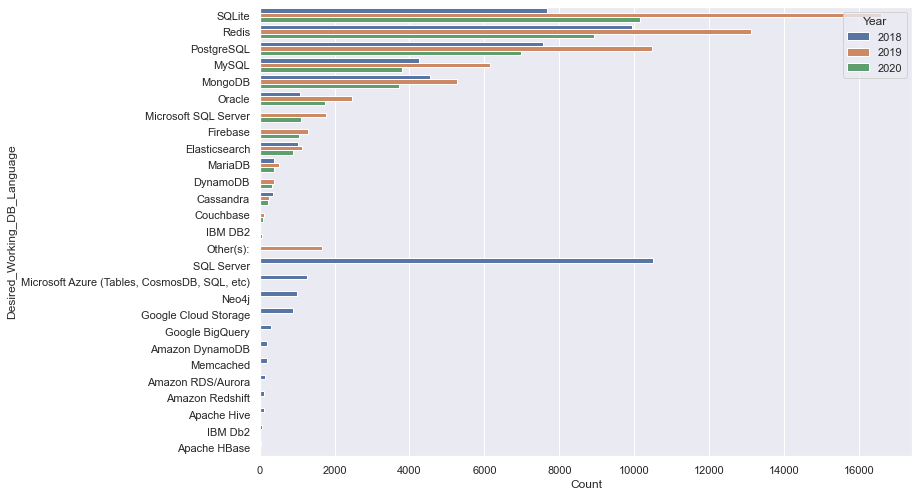

In [26]:
print(len(DB_df_final))
sns.set(rc={'figure.figsize':(11.7,8.27)})


sns.barplot(x = 'Count', 
            y = 'Desired_Working_DB_Language',
            hue = 'Year',
            data = DB_df_final)

## Comparing Programing languages

In [27]:
# Create combined dataset for Prog Lang
Current_vs_Desired_Lang = create_combined_dataset(datasets=[Data2017, Data2018, Data2019, Data2020], Prog_or_DB='Prog')

# Drop rows with all nulls
Current_vs_Desired_Lang = Current_vs_Desired_Lang.dropna(subset=['LanguageWorkedWith', 'LanguageDesireNextYear'], how='all', axis=0)

# Unifying column names
Current_vs_Desired_Lang = unify_Lang_column_names(Current_vs_Desired_Lang)
Current_vs_Desired_Lang.head(10)




,Respondent,Year,CurrentWorkingLanguage,DesiredLanguage
0,1,2018,JavaScript;Python;HTML;CSS,JavaScript;Python;HTML;CSS
1,3,2018,JavaScript;Python;Bash/Shell,Go;Python
3,5,2018,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell
4,7,2018,C;C++;Java;Matlab;R;SQL;Bash/Shell,Assembly;C;C++;Matlab;SQL;Bash/Shell
5,8,2018,Java;JavaScript;Python;TypeScript;HTML;CSS,C#;Go;Java;JavaScript;Python;SQL;TypeScript;HT...
6,9,2018,JavaScript;HTML;CSS,C;Go;JavaScript;Python;HTML;CSS
7,10,2018,JavaScript;TypeScript;HTML;CSS,Matlab;SQL;Kotlin;Bash/Shell
8,11,2018,Assembly;CoffeeScript;Erlang;Go;JavaScript;Lua...,Erlang;Go;Python;Rust;SQL
13,20,2018,Java,Java;Python
14,21,2018,Java;JavaScript;PHP;VB.NET;HTML;CSS,


In [28]:
## Current Lag alone
Current_Lang_df = Current_vs_Desired_Lang.assign(var1=Current_vs_Desired_Lang['CurrentWorkingLanguage'].str.split(';')).explode('var1')

Current_Lang_df.rename(columns={'var1':'Current_Working_Language'}, inplace=True)
Current_Lang_df.drop(columns=['CurrentWorkingLanguage','DesiredLanguage'], inplace=True)
Current_Lang_df.head(10)

,Respondent,Year,Current_Working_Language
0,1,2018,JavaScript
0,1,2018,Python
0,1,2018,HTML
0,1,2018,CSS
1,3,2018,JavaScript
1,3,2018,Python
1,3,2018,Bash/Shell
3,5,2018,C#
3,5,2018,JavaScript
3,5,2018,SQL


In [29]:
## Desired Languages alone
Desired_Lang_df = Current_vs_Desired_Lang.assign(var1=Current_vs_Desired_Lang['DesiredLanguage'].str.split(';')).explode('var1')

Desired_Lang_df.rename(columns={'var1':'Desired_Working_Language'}, inplace=True)
Desired_Lang_df.drop(columns=['CurrentWorkingLanguage','DesiredLanguage'], inplace=True)

Desired_Lang_df.head(10)




,Respondent,Year,Desired_Working_Language
0,1,2018,JavaScript
0,1,2018,Python
0,1,2018,HTML
0,1,2018,CSS
1,3,2018,Go
1,3,2018,Python
3,5,2018,C#
3,5,2018,JavaScript
3,5,2018,SQL
3,5,2018,TypeScript


In [30]:
#compare
# Current_Lang_df
# Desired_Lang_df
# What is in Current found in Desired


Lang_df = pd.merge(Current_Lang_df, Desired_Lang_df, how='left', on=['Respondent','Year'])
   

Lang_df.loc[Lang_df['Current_Working_Language'] != Lang_df['Desired_Working_Language'],'Desired_Working_Language'] = np.nan
Lang_df.sort_values(by=['Respondent','Year','Current_Working_Language','Desired_Working_Language'], ascending=False, inplace=True)
Lang_df.drop_duplicates(subset=['Respondent','Year','Current_Working_Language'], inplace=True)
Lang_df[Lang_df['Respondent']==1]


## Count common between desired and current
len(Lang_df[Lang_df['Desired_Working_Language'].isnull() == False])/len(Lang_df) ## 54%
Lang_df
Lang_df_final = Lang_df[Lang_df['Desired_Working_Language'].isnull() == False].drop('Respondent', axis=1)
# Lang_df_final = Lang_df_final.drop('Respondent', axis=1)
Lang_df_final = Lang_df_final.value_counts()
Lang_df_final = Lang_df_final.to_frame().reset_index()
Lang_df_final.columns = ['Year','Current_Working_Language','Desired_Working_Language','Count']

Lang_df_final = Lang_df_final.sort_values(by=['Year','Count'], ascending=False)
Lang_df_final.to_csv('CommonProgLangTable.csv')
Lang_df_final

,Year,Current_Working_Language,Desired_Working_Language,Count
8,2020,JavaScript,JavaScript,22639
10,2020,HTML/CSS,HTML/CSS,19356
16,2020,SQL,SQL,17778
17,2020,Python,Python,16858
20,2020,C#,C#,10762
...,...,...,...,...
86,2018,Visual Basic 6,Visual Basic 6,312
87,2018,Julia,Julia,227
88,2018,Ocaml,Ocaml,195
89,2018,Hack,Hack,107


91


<AxesSubplot:xlabel='Count', ylabel='Current_Working_Language'>

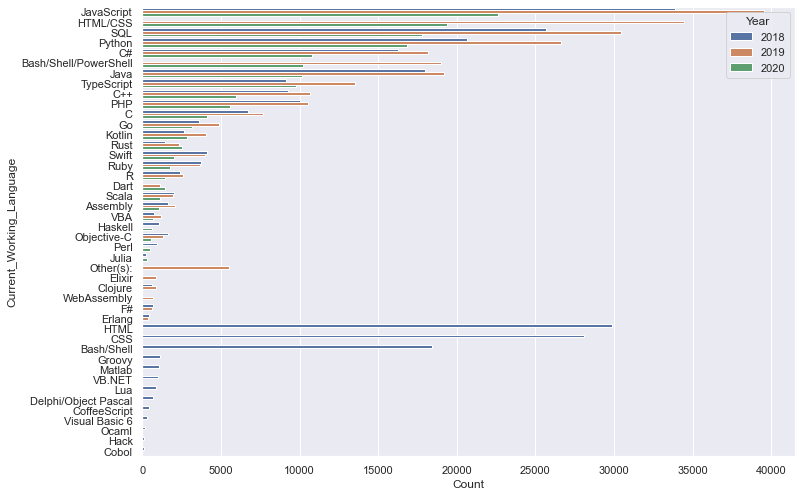

In [31]:
print(len(Lang_df_final))
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x = 'Count', 
            y = 'Current_Working_Language',
            hue = 'Year',
            data = Lang_df_final)

In [32]:
#compare
# Current_Lang_df
# Desired_Lang_df
# What is in Desired not found in Current


Lang_df = pd.merge(Current_Lang_df, Desired_Lang_df, how='right', on=['Respondent','Year'])
   

Lang_df.loc[Lang_df['Current_Working_Language'] != Lang_df['Desired_Working_Language'],'Current_Working_Language'] = np.nan
Lang_df.sort_values(by=['Respondent','Year','Current_Working_Language','Desired_Working_Language'], ascending=False, inplace=True)
Lang_df.drop_duplicates(subset=['Respondent','Year','Current_Working_Language'], inplace=True)
Lang_df[Lang_df['Respondent']==1]


## Count not found in Current
print(len(Lang_df[Lang_df['Current_Working_Language'].isnull() == True])/len(Lang_df)) ## 37.8%
Lang_df
Lang_df_final = Lang_df[Lang_df['Current_Working_Language'].isnull() == True].drop(['Respondent','Current_Working_Language'], axis=1)
Lang_df_final = Lang_df_final.value_counts()
Lang_df_final = Lang_df_final.to_frame().reset_index()
Lang_df_final.columns = ['Year','Desired_Working_Language','Count']

Lang_df_final = Lang_df_final.sort_values(by=['Year','Count'], ascending=False)
Lang_df_final.to_csv('InDesiredProgLangTable.csv')
Lang_df_final

0.24525125672692455


,Year,Desired_Working_Language,Count
2,2020,TypeScript,16775
6,2020,SQL,10203
10,2020,Python,6640
13,2020,Rust,4283
16,2020,,3666
...,...,...,...
88,2018,CoffeeScript,34
89,2018,Groovy,33
91,2018,Hack,24
92,2018,Cobol,9


94


<AxesSubplot:xlabel='Count', ylabel='Desired_Working_Language'>

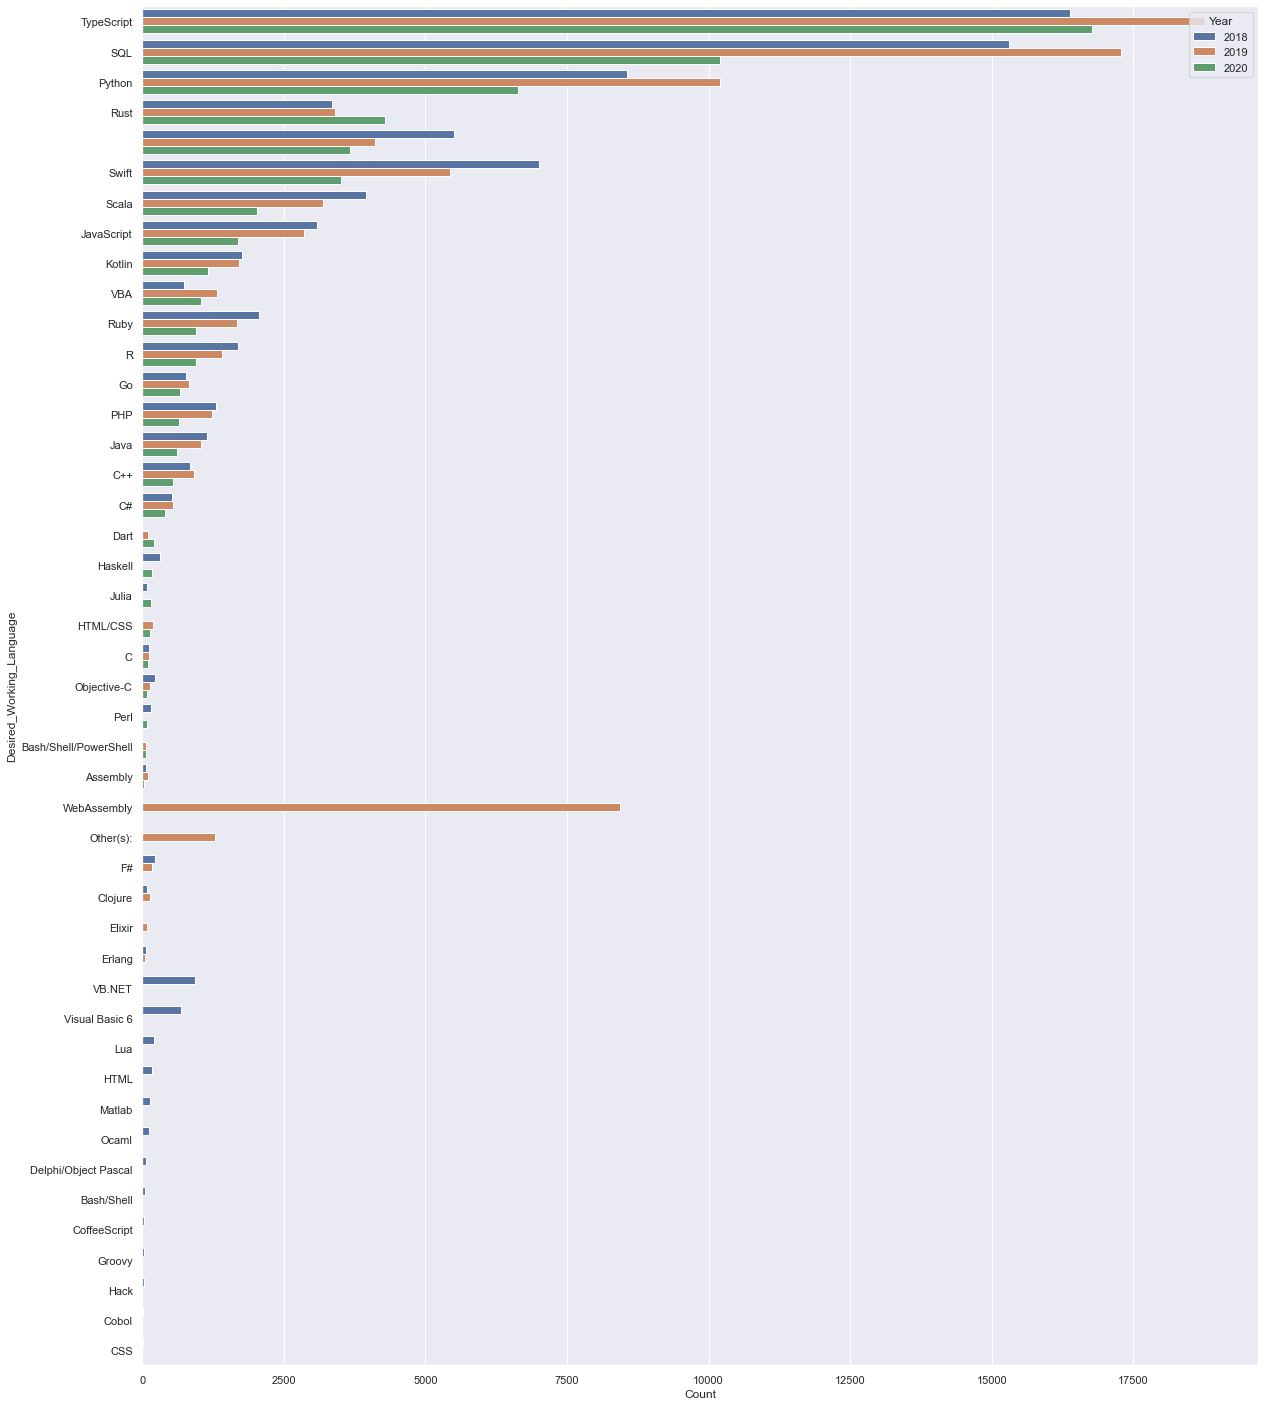

In [33]:
print(len(Lang_df_final))
sns.set(rc={'figure.figsize':(20,25)})


sns.barplot(x = 'Count', 
            y = 'Desired_Working_Language',
            hue = 'Year',
            data = Lang_df_final)